In [4]:
# Mendefinisikan direktori utama dataset
#dataset ini upload terlebih dulu ke drive agar bisa di load di google colab,
#atau kalian bisa langsung download lewat kaggle langsung di google colab

import os
from google.colab import drive
import os
drive.mount('/content/drive')
base_dir = '/content/drive/My Drive/Colab Notebooks/tomato/train'

Mounted at /content/drive


In [5]:
print(os.listdir(base_dir))

['Bacterial_spot', 'healthy', 'Early_blight', 'Late_blight', 'Leaf_Mold']


In [6]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 5000


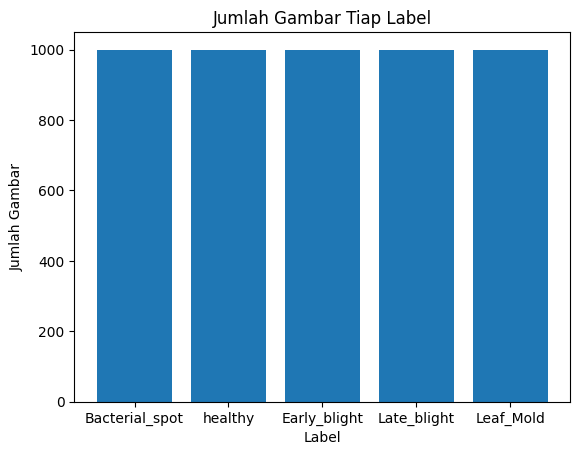

In [7]:
# Visualisasi jumlah gambar tiap kelas
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

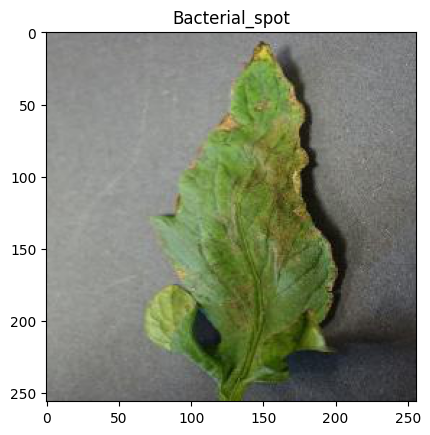

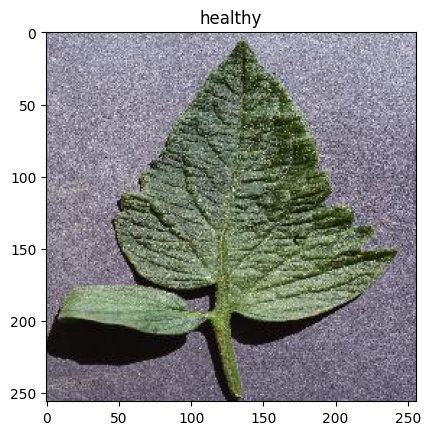

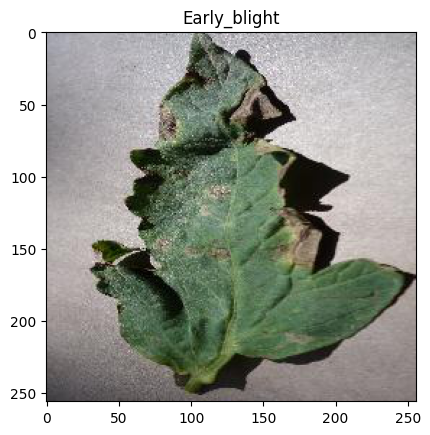

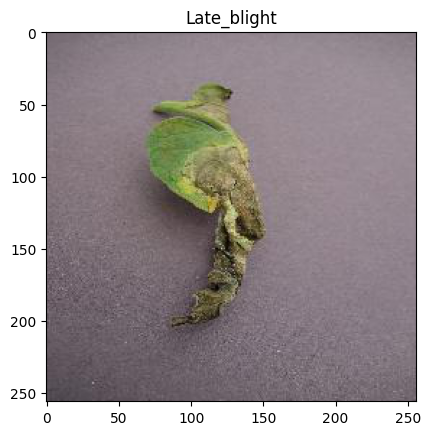

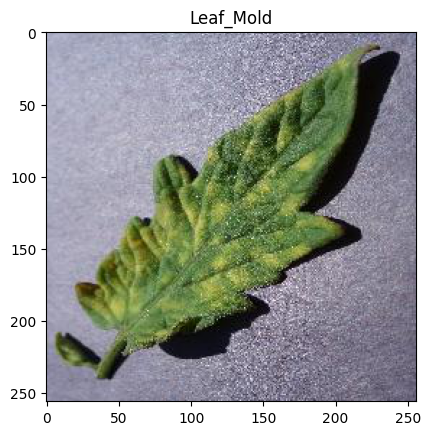

In [8]:
# Menampilkan sampel gambar tiap kelas
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

In [9]:
IMAGE_SIZE = (200,200)
BATCH_SIZE = 32
SEED = 999

In [10]:
# Menggunakan ImageDataGenerator untuk preprocessing
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [11]:
# Menyiapkan data train dan data validation
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [12]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

In [13]:
# Membuat arsitektur model CNN
cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [14]:
# Training model CNN
cnn_hist = cnn_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
125/125 [==============================] - 2535s 20s/step - loss: 1.1313 - accuracy: 0.5075 - val_loss: 2.8006 - val_accuracy: 0.3660
Epoch 2/20
125/125 [==============================] - 19s 151ms/step - loss: 0.5949 - accuracy: 0.7755 - val_loss: 1.6880 - val_accuracy: 0.5880
Epoch 3/20
125/125 [==============================] - 19s 151ms/step - loss: 0.4599 - accuracy: 0.8202 - val_loss: 1.3937 - val_accuracy: 0.6200
Epoch 4/20
125/125 [==============================] - 20s 161ms/step - loss: 0.3784 - accuracy: 0.8595 - val_loss: 1.4272 - val_accuracy: 0.6460
Epoch 5/20
125/125 [==============================] - 19s 150ms/step - loss: 0.3532 - accuracy: 0.8627 - val_loss: 1.5279 - val_accuracy: 0.6420
Epoch 6/20
125/125 [==============================] - 19s 151ms/step - loss: 0.3018 - accuracy: 0.8867 - val_loss: 1.2284 - val_accuracy: 0.7060
Epoch 7/20
125/125 [==============================] - 21s 169ms/step - loss: 0.3732 - accuracy: 0.8558 - val_loss: 1.3046 - val_ac

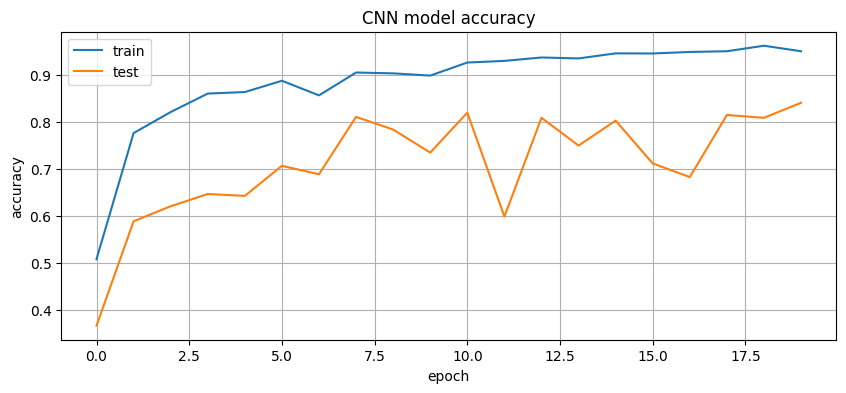

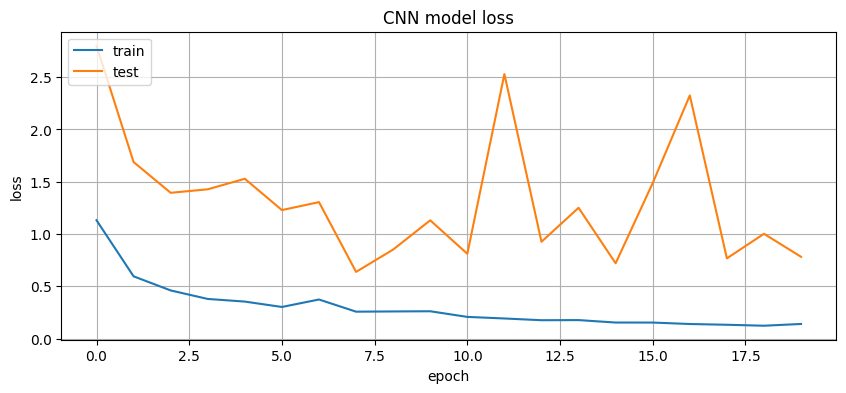

In [15]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [16]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_vgg_model.trainable = False

# Preprocessing Input
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input
train_data.preprocessing_function = vgg_preprocess

58889256/58889256 [==============================] - 4s 0us/step


In [17]:
# Transfer learning dengan VGG16
vgg_model = tf.keras.models.Sequential([
  data_augmentation,
  base_vgg_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [18]:
# Melatih model VGG16
vgg_hist = vgg_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
125/125 [==============================] - 30s 187ms/step - loss: 0.9935 - accuracy: 0.6120 - val_loss: 0.5319 - val_accuracy: 0.8070
Epoch 2/20
125/125 [==============================] - 22s 177ms/step - loss: 0.5910 - accuracy: 0.7663 - val_loss: 0.3898 - val_accuracy: 0.8550
Epoch 3/20
125/125 [==============================] - 22s 174ms/step - loss: 0.5200 - accuracy: 0.7997 - val_loss: 0.3816 - val_accuracy: 0.8540
Epoch 4/20
125/125 [==============================] - 21s 171ms/step - loss: 0.4853 - accuracy: 0.8138 - val_loss: 0.3206 - val_accuracy: 0.8880
Epoch 5/20
125/125 [==============================] - 23s 184ms/step - loss: 0.4358 - accuracy: 0.8390 - val_loss: 0.3748 - val_accuracy: 0.8500
Epoch 6/20
125/125 [==============================] - 21s 171ms/step - loss: 0.4244 - accuracy: 0.8418 - val_loss: 0.2861 - val_accuracy: 0.8980
Epoch 7/20
125/125 [==============================] - 22s 178ms/step - loss: 0.3937 - accuracy: 0.8512 - val_loss: 0.2932 - val_ac

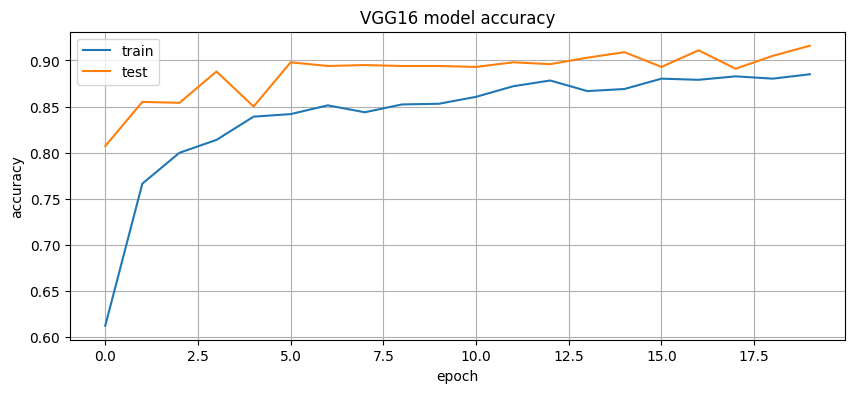

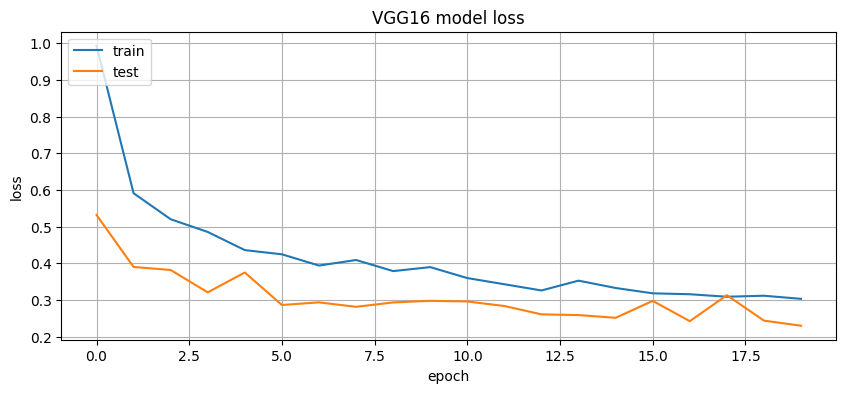

In [19]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [20]:
from tensorflow.keras.applications import ResNet50

# Loading ResNet50 model
base_resnet_model = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
                   pooling='max',classes=5,
                   weights='imagenet')

base_resnet_model.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet50.preprocess_input


# Transfer learning ResNet50
resnet_model = tf.keras.models.Sequential([
    data_augmentation,
    base_resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax")
])

94765736/94765736 [==============================] - 5s 0us/step


In [21]:
# Compiling model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [22]:
# Melatih model ResNet50
resnet_hist = resnet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
125/125 [==============================] - 28s 179ms/step - loss: 1.6432 - accuracy: 0.2490 - val_loss: 1.5591 - val_accuracy: 0.2370
Epoch 2/20
125/125 [==============================] - 20s 163ms/step - loss: 1.5260 - accuracy: 0.2890 - val_loss: 1.4574 - val_accuracy: 0.3400
Epoch 3/20
125/125 [==============================] - 20s 159ms/step - loss: 1.4531 - accuracy: 0.3543 - val_loss: 1.4304 - val_accuracy: 0.3940
Epoch 4/20
125/125 [==============================] - 21s 165ms/step - loss: 1.4381 - accuracy: 0.3677 - val_loss: 1.3995 - val_accuracy: 0.4000
Epoch 5/20
125/125 [==============================] - 21s 171ms/step - loss: 1.3842 - accuracy: 0.3850 - val_loss: 1.4208 - val_accuracy: 0.3970
Epoch 6/20
125/125 [==============================] - 22s 172ms/step - loss: 1.3403 - accuracy: 0.4225 - val_loss: 1.3223 - val_accuracy: 0.4490
Epoch 7/20
125/125 [==============================] - 20s 158ms/step - loss: 1.3212 - accuracy: 0.4193 - val_loss: 1.2693 - val_ac

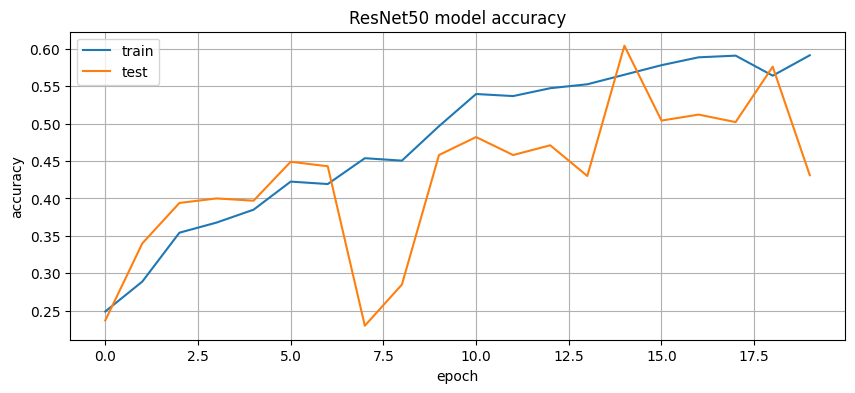

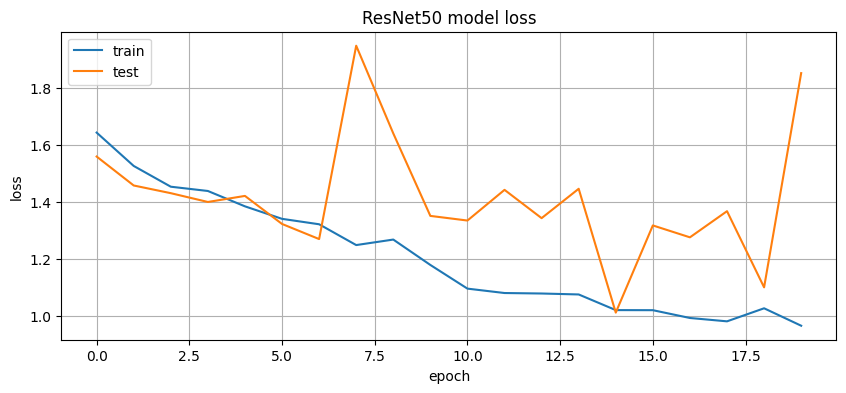

In [23]:
# Membuat plot akurasi model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [24]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

74836368/74836368 [==============================] - 4s 0us/step


In [25]:
# Transfer learning DenseNet201
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [26]:
# Melatih model DenseNet201
densenet_hist = densenet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
125/125 [==============================] - 43s 224ms/step - loss: 0.8477 - accuracy: 0.6695 - val_loss: 0.6010 - val_accuracy: 0.7880
Epoch 2/20
125/125 [==============================] - 22s 179ms/step - loss: 0.4621 - accuracy: 0.8370 - val_loss: 0.2938 - val_accuracy: 0.8930
Epoch 3/20
125/125 [==============================] - 21s 167ms/step - loss: 0.4112 - accuracy: 0.8472 - val_loss: 0.3208 - val_accuracy: 0.8830
Epoch 4/20
125/125 [==============================] - 22s 173ms/step - loss: 0.3504 - accuracy: 0.8758 - val_loss: 0.3052 - val_accuracy: 0.8810
Epoch 5/20
125/125 [==============================] - 21s 171ms/step - loss: 0.3347 - accuracy: 0.8733 - val_loss: 0.2346 - val_accuracy: 0.9150
Epoch 6/20
125/125 [==============================] - 22s 179ms/step - loss: 0.3056 - accuracy: 0.8898 - val_loss: 0.2496 - val_accuracy: 0.9030
Epoch 7/20
125/125 [==============================] - 21s 170ms/step - loss: 0.2622 - accuracy: 0.9028 - val_loss: 0.3602 - val_ac

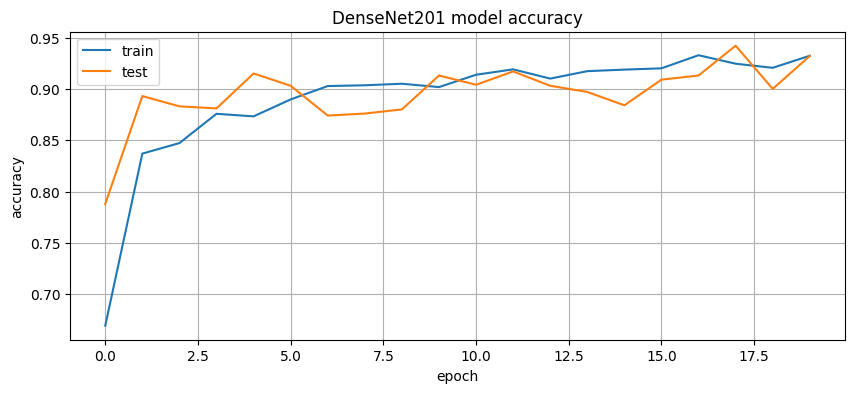

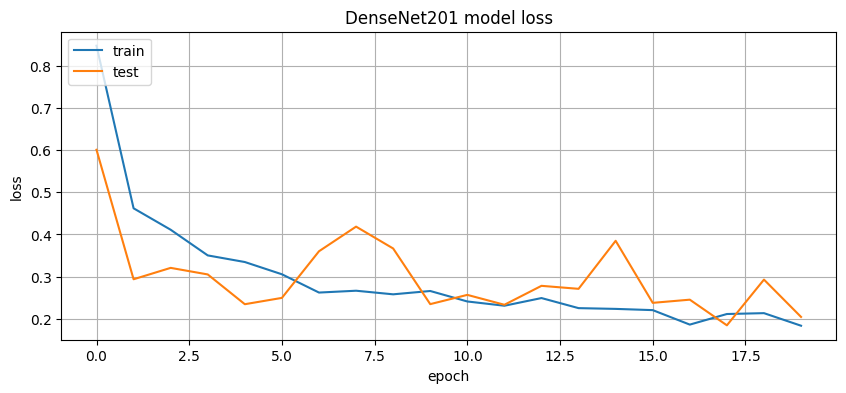

In [27]:
# Membuat plot akurasi model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('DenseNet201 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('DenseNet201 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

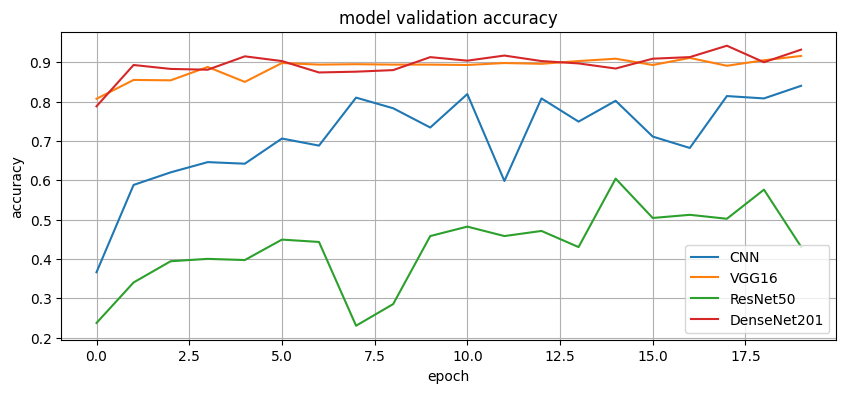

In [28]:
# Membuat plot akurasi empat model sebelumnya untuk dibandingkan
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'VGG16', 'ResNet50', 'DenseNet201'], loc='lower right')
plt.grid(True)
plt.show()

In [29]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

{'Bacterial_spot': 0,
 'Early_blight': 1,
 'Late_blight': 2,
 'Leaf_Mold': 3,
 'healthy': 4}

In [30]:
import numpy as np
from keras.preprocessing import image
from google.colab import files
import matplotlib.pyplot as plt
import keras.utils as image

In [31]:
IMAGE_SIZE = (200, 200)

Saving tomato-leaf-mold-comparison.png to tomato-leaf-mold-comparison.png
1/1 [==============================] - 0s 35ms/step
tomato-leaf-mold-comparison.png
Blight akhir


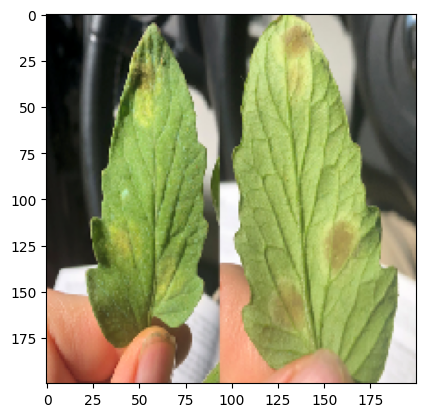

In [40]:
uploaded = files.upload()

for fn in uploaded.keys():
  # Prediksi gambar
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = x
  classes = densenet_model.predict(images)
  classes = np.argmax(classes)

  print(fn)
  if classes == 0:
    print('Noda Bakteri')
  elif classes == 1:
    print('Blight awal')
  elif classes == 2:
    print('Blight akhir')
  elif classes == 3:
    print('Mold')
  else:
    print('Sehat')

In [33]:
densenet_model.save('model-flowers-recognition.h5')

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(densenet_model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model-flowers-recognition.tflite', 'wb') as f:
  f.write(tflite_model)

KeyboardInterrupt: ignored